In [1]:
import torch
import torch.nn as nn
import os
import pickle
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
# NOTE: from this point, we are in the SimCLR_dshustin directory.
os.chdir('SimCLR')
from SimCLR.models.mlp_simclr import MLPSimCLR

In [6]:
setting = 'shap_e' #Options: {'shap_e', 'effnet'}

# Replace with path to checkpoint.
# AFTER HYPERPARAMETER SWEEP (note: using top1 on simclr as proxy. probably should just run this evaluation pipeline, shouldn't be hard)
# chkpt_path = '/n/fs/scratch/dshustin/golden-retriever/SimCLR/runs/May13_07-44-38_node301.ionic.cs.princeton.edu/checkpoint_0200.pth.tar' # best effnet model from hp sweep. hidden-num=3    --hidden-dim=500        --out-dim=128   --proj-dim=250  
chkpt_path = '/n/fs/scratch/dshustin/golden-retriever/SimCLR/runs/May13_10-49-02_node301.ionic.cs.princeton.edu/checkpoint_0200.pth.tar' # best shap_e model from hp sweep. hidden-num=5    --hidden-dim=250        --out-dim=128   --proj-dim=500  loss=0.27523157000541687

# Load full SimCLR encoder from checkpoint
chkpt = torch.load(chkpt_path)
simclr_mdl = MLPSimCLR(**chkpt['arch']).to('cpu')
simclr_mdl.load_state_dict(chkpt['state_dict'])
simclr_mdl

MLPSimCLR(
  (backbone): Sequential(
    (0): Linear(in_features=1048576, out_features=250, bias=True)
    (1): ReLU()
    (2): Linear(in_features=250, out_features=250, bias=True)
    (3): ReLU()
    (4): Linear(in_features=250, out_features=250, bias=True)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=250, bias=True)
    (7): ReLU()
    (8): Linear(in_features=250, out_features=250, bias=True)
    (9): ReLU()
    (10): Linear(in_features=250, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=128, bias=True)
    (13): ReLU()
  )
)

In [7]:
# Cut out projection head
model_layers = list(simclr_mdl.backbone.children())[:-2] # TODO: should we cut out the ReLU here?
model = nn.Sequential(*model_layers)
model

Sequential(
  (0): Linear(in_features=1048576, out_features=250, bias=True)
  (1): ReLU()
  (2): Linear(in_features=250, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=250, bias=True)
  (5): ReLU()
  (6): Linear(in_features=250, out_features=250, bias=True)
  (7): ReLU()
  (8): Linear(in_features=250, out_features=250, bias=True)
  (9): ReLU()
  (10): Linear(in_features=250, out_features=500, bias=True)
  (11): ReLU()
)

In [8]:
# Load test data into memory
# load dataset metadata
data_path = '/n/fs/scratch/dshustin/srn_cars_val_retrieval_large.pickle'
embeds_path = f'/n/fs/scratch/dshustin/srn_cars_val_{setting}_large_index.pickle'
print('Loading data from', data_path)
print('Loading embeds from', embeds_path)
with open(data_path, 'rb') as f:
    db_ids, query_ids, _, _ = pickle.load(f)
with open(embeds_path, 'rb') as f:
    db_id_to_embed_paths, query_id_to_embed_paths = pickle.load(f)

Loading data from /n/fs/scratch/dshustin/srn_cars_val_retrieval_large.pickle
Loading embeds from /n/fs/scratch/dshustin/srn_cars_val_shap_e_large_index.pickle


In [10]:
# Load all embeds and scene labels into memory
# NOTE: This step can take a long time!
db_embed_labels = []
db_embed_data = []
query_embed_labels = []
query_embed_data = []
db_k = chkpt['db_k'] if 'db_k' in chkpt else 20
for label, db_id in tqdm(enumerate(db_ids)):
    # Load scene views from db
    db_id_paths = db_id_to_embed_paths[db_id][:db_k] # Evaluate on data from training
    npaths = len(db_id_paths)
    
    db_embed_labels.extend([label] * npaths)
    db_embed_data.extend([np.load(path) for path in db_id_paths])
    
    # Load corresponding query view of same scene, if exists
    # query_ids should be a subset of db_ids
    if db_id in query_ids:
        query_id_paths = query_id_to_embed_paths[db_id] # get query corresponding to db entry
        nquerypaths = len(query_id_paths)
        query_embed_labels.extend([label] * nquerypaths)
        query_embed_data.extend([np.load(path) for path in query_id_paths])
        
embed_data = np.array(db_embed_data + query_embed_data)
db_embed_data = np.array(db_embed_data)
query_embed_data = np.array(query_embed_data)
print(f"Loaded {embed_data.shape[0]} embeddings, each {embed_data.shape[1]}-dimensional")

300it [07:25,  1.49s/it]


Loaded 6050 embeddings, each 1048576-dimensional


In [11]:
# Evaluate contrastive learned encoder on embedding (using CPU)
n_db = len(db_embed_data)
with torch.no_grad():
    eval_model = model.eval().cpu() # NOTE: Can use simclr_mdl here to add back projection head
    transformed_embed = eval_model(torch.from_numpy(embed_data))
    transformed_db_embed = eval_model(torch.from_numpy(np.array(db_embed_data)))
    transformed_query_embed = eval_model(torch.from_numpy(np.array(query_embed_data)))

torch.Size([6050, 500])

## Calculate accuracy

In [12]:
# Zero-Shot Eval
query_embed_mat = np.array(query_embed_data)
db_embed_mat = np.array(db_embed_data)

# Normalize each row
query_embed_mat = query_embed_mat / np.sqrt(np.sum(np.square(query_embed_mat), axis=1))[:,None]
db_embed_mat = db_embed_mat / np.sqrt(np.sum(np.square(db_embed_mat), axis=1))[:,None]

In [13]:
# Compute similarity matrix (matrix of inner products)
# I want: a_ij to be query i \cdot db j
similarity_mat = query_embed_mat @ db_embed_mat.transpose()
similarity_mat.shape

(50, 6000)

In [18]:
# Great! Now we can find our metrics
# Convert labels to numpy arrays
db_label_np = np.array(db_embed_labels)
query_label_np = np.array(query_embed_labels)
nqueries = query_label_np.shape[0]

# We will be doing Recall@k
k = 5

# Compute labels of relevant predictions (Top1, Topk)
pred_toplabel = db_label_np[np.argmax(similarity_mat, axis=1)]
pred_klabel = db_label_np[np.argpartition(-similarity_mat, (0,1,2,3,4), axis=1)[:,:k]] # negative to find largest dot product
# Check whether label is found in Topk
pred_found_klabel = np.max(query_label_np[:, None] == pred_klabel, axis = 1)

# Compute labels of all predictions
pred_allguesses = db_label_np[np.argsort(-similarity_mat, axis=1)]
# Find rank of first correct prediction (for MRR)
first_good_guess = np.argmax(query_label_np[:, None] == pred_allguesses, axis=1) + 1

# Calculate metrics
toponeacc = np.sum(query_label_np == pred_toplabel) / nqueries
topkacc = np.sum(pred_found_klabel) / nqueries
mrr = np.sum(1/first_good_guess) / nqueries
print("===== Zero-shot eval =====")
print(f"Top1 acc:\t{toponeacc*100:.5f}")
print(f"Top{k} acc:\t{topkacc*100:.5f}%")
print(f"Mean Recip.:\t{mrr*100:.5f}%")

===== Zero-shot eval =====
Top1 acc:	86.00000
Top5 acc:	96.00000%
Mean Recip.:	90.00379%


In [19]:
# Learned Embedding Eval (overwrites previous eval)
query_embed_mat = transformed_query_embed.cpu().numpy()
db_embed_mat = transformed_db_embed.cpu().numpy()

# Normalize each row
query_embed_mat = query_embed_mat / np.sqrt(np.sum(np.square(query_embed_mat), axis=1))[:,None]
db_embed_mat = db_embed_mat / np.sqrt(np.sum(np.square(db_embed_mat), axis=1))[:,None]

In [20]:
# Compute similarity matrix (matrix of inner products)
# I want: a_ij to be query i \cdot db j
similarity_mat = query_embed_mat @ db_embed_mat.transpose()
similarity_mat.shape

(50, 6000)

In [21]:
# Great! Now we can find our metrics
# Convert labels to numpy arrays
db_label_np = np.array(db_embed_labels)
query_label_np = np.array(query_embed_labels)
nqueries = query_label_np.shape[0]

# We will be doing Recall@k
k = 5

# Compute labels of relevant predictions (Top1, Topk)
pred_toplabel = db_label_np[np.argmax(similarity_mat, axis=1)]
pred_klabel = db_label_np[np.argpartition(-similarity_mat, (0,1,2,3,4), axis=1)[:,:k]] # negative to find largest dot product
# Check whether label is found in Topk
pred_found_klabel = np.max(query_label_np[:, None] == pred_klabel, axis = 1)

# Compute labels of all predictions
pred_allguesses = db_label_np[np.argsort(-similarity_mat, axis=1)]
# Find rank of first correct prediction (for MRR)
first_good_guess = np.argmax(query_label_np[:, None] == pred_allguesses, axis=1) + 1

# Calculate metrics
toponeacc = np.sum(query_label_np == pred_toplabel) / nqueries
topkacc = np.sum(pred_found_klabel) / nqueries
mrr = np.sum(1/first_good_guess) / nqueries
print("===== SimCLR eval =====")
print(f"Top1 acc:\t{toponeacc*100:.5f}")
print(f"Top{k} acc:\t{topkacc*100:.5f}%")
print(f"Mean Recip.:\t{mrr*100:.5f}%")

===== SimCLR eval =====
Top1 acc:	88.00000
Top5 acc:	94.00000%
Mean Recip.:	90.86147%


## Generate TSNEs of data

In [22]:
# Run all encoded data through t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=123, metric='cosine')
z = tsne.fit_transform(transformed_embed.cpu().numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6050 samples in 0.001s...
[t-SNE] Computed neighbors for 6050 samples in 0.365s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6050
[t-SNE] Computed conditional probabilities for sample 2000 / 6050
[t-SNE] Computed conditional probabilities for sample 3000 / 6050
[t-SNE] Computed conditional probabilities for sample 4000 / 6050
[t-SNE] Computed conditional probabilities for sample 5000 / 6050
[t-SNE] Computed conditional probabilities for sample 6000 / 6050
[t-SNE] Computed conditional probabilities for sample 6050 / 6050
[t-SNE] Mean sigma: 0.028168
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.533707
[t-SNE] KL divergence after 1000 iterations: 0.563937


Text(0.5, 1.0, 't-SNE: Contrastive-Learned Space, shap_e')

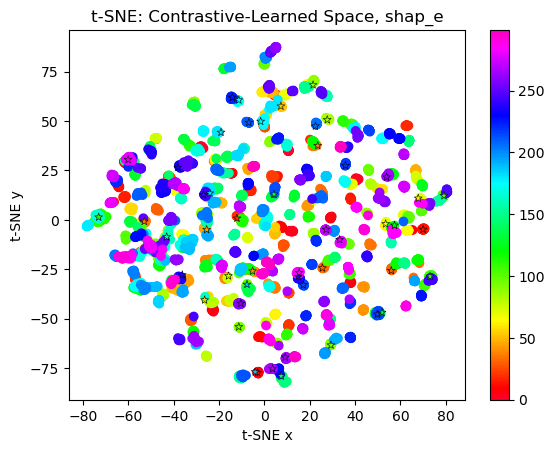

In [23]:
cb = plt.scatter(z[:n_db, 0], z[:n_db, 1], c=db_embed_labels, cmap='gist_rainbow') # scatter database points
plt.scatter(z[n_db:, 0], z[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
plt.colorbar()
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")
plt.title(f"t-SNE: Contrastive-Learned Space, {setting}")

Text(0.5, 1.0, 't-SNE (heatmap): Contrastive-Learned Space, shap_e')

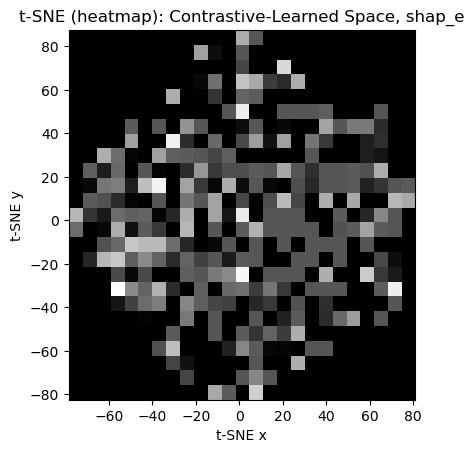

In [24]:
# Generate heatmap
db_points_hist, xedges, yedges = np.histogram2d(z[:n_db, 0], z[:n_db, 1], 25)
plt.imshow(db_points_hist.T, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='gray')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.title(f't-SNE (heatmap): Contrastive-Learned Space, {setting}')

In [25]:
# Generate t-SNE of original embeddings (before contrastive learning)
# NOTE: This can take a long time! Shap-E is very high dimensional
from datetime import datetime
print("Started:", datetime.now())
tsne = TSNE(n_components=2, verbose=1, random_state=123, metric='cosine')
z_pretrain = tsne.fit_transform(embed_data) # include queries in transformed embed to avoid artifacts of t-SNE. this doesn't feel like cheating
z_pretrain.shape
print("Finished:", datetime.now())

Started: 2023-05-15 02:49:47.716702
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6050 samples in 2.715s...
[t-SNE] Computed neighbors for 6050 samples in 75.993s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6050
[t-SNE] Computed conditional probabilities for sample 2000 / 6050
[t-SNE] Computed conditional probabilities for sample 3000 / 6050
[t-SNE] Computed conditional probabilities for sample 4000 / 6050
[t-SNE] Computed conditional probabilities for sample 5000 / 6050
[t-SNE] Computed conditional probabilities for sample 6000 / 6050
[t-SNE] Computed conditional probabilities for sample 6050 / 6050
[t-SNE] Mean sigma: 0.074944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.775482
[t-SNE] KL divergence after 1000 iterations: 1.467362
Finished: 2023-05-15 02:52:22.965226


Text(0.5, 1.0, 't-SNE: Original Embedding, shap_e')

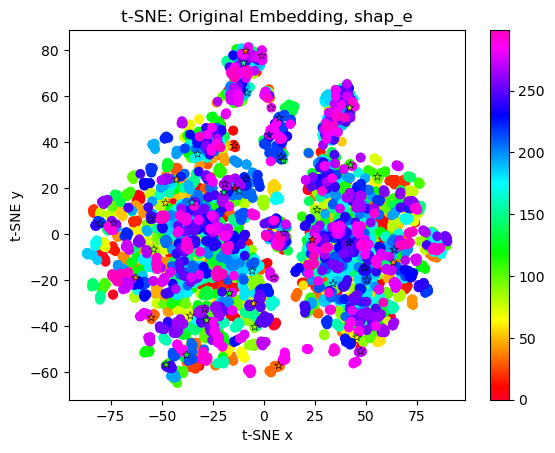

In [26]:
cb = plt.scatter(z_pretrain[:n_db, 0], z_pretrain[:n_db, 1], c=db_embed_labels, cmap='gist_rainbow') # scatter database points
plt.scatter(z_pretrain[n_db:, 0], z_pretrain[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
plt.colorbar()
plt.xlabel("t-SNE x")
plt.ylabel("t-SNE y")
plt.title(f"t-SNE: Original Embedding, {setting}")
# plt.legend(handles=scatter.legend_elements()[0],
#            labels=db_ids,
#            title='Image ID')

Text(0.5, 1.0, 't-SNE (heatmap): Original Embedding, shap_e')

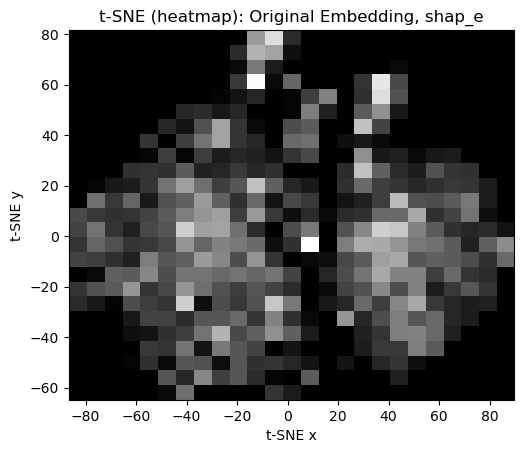

In [27]:
db_points_hist_pretrain, xedges_pretrain, yedges_pretrain = np.histogram2d(z_pretrain[:n_db, 0], z_pretrain[:n_db, 1], 25)
plt.imshow(db_points_hist_pretrain.T, interpolation='nearest', origin='lower',
        extent=[xedges_pretrain[0], xedges_pretrain[-1], yedges_pretrain[0], yedges_pretrain[-1]], cmap='gray')
plt.xlabel('t-SNE x')
plt.ylabel('t-SNE y')
plt.title(f"t-SNE (heatmap): Original Embedding, {setting}")

Text(0.5, 1.0, 't-SNE, SimCLR Embedding, Shap-E')

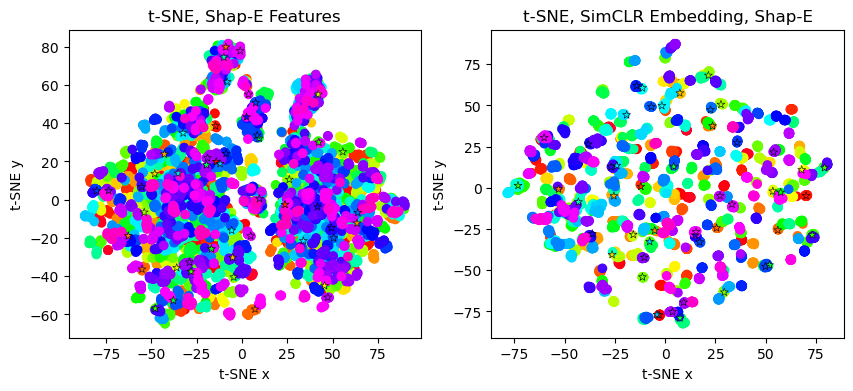

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.scatter(z_pretrain[:n_db, 0], z_pretrain[:n_db, 1], c=db_embed_labels, cmap='gist_rainbow') # scatter database points
ax1.scatter(z_pretrain[n_db:, 0], z_pretrain[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
ax1.set_xlabel('t-SNE x')
ax1.set_ylabel('t-SNE y')
ax1.set_title(f"t-SNE, {'Efficientnet-b7' if setting == 'effnet' else 'Shap-E'} Features")

ax2.scatter(z[:n_db, 0], z[:n_db, 1], c=db_embed_labels, cmap='gist_rainbow') # scatter database points
ax2.scatter(z[n_db:, 0], z[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
ax2.set_xlabel('t-SNE x')
ax2.set_ylabel('t-SNE y')
ax2.set_title(f"t-SNE, SimCLR Embedding, {'Efficientnet-b7' if setting == 'effnet' else 'Shap-E'}")


Text(0.5, 1.0, 't-SNE, SimCLR Embedding, Shap-E')

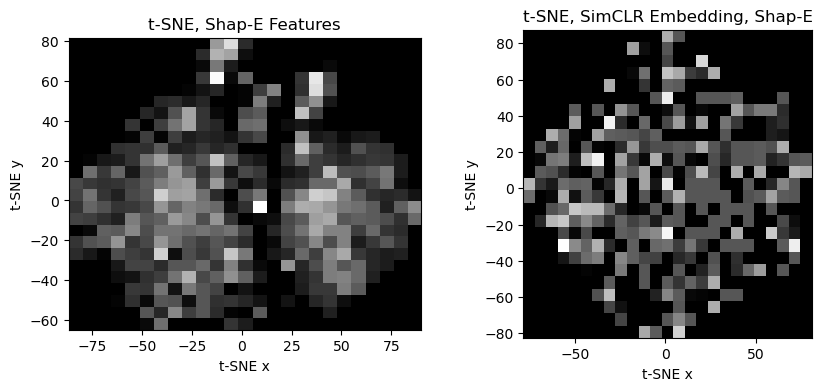

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
ax1.imshow(db_points_hist_pretrain.T, interpolation='nearest', origin='lower',
        extent=[xedges_pretrain[0], xedges_pretrain[-1], yedges_pretrain[0], yedges_pretrain[-1]], cmap='gray') # scatter database points
# ax1.scatter(z_pretrain[n_db:, 0], z_pretrain[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
ax1.set_xlabel('t-SNE x')
ax1.set_ylabel('t-SNE y')
ax1.set_title(f"t-SNE, {'Efficientnet-b7' if setting == 'effnet' else 'Shap-E'} Features")

ax2.imshow(db_points_hist.T, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='gray') # scatter database points
# ax2.scatter(z[n_db:, 0], z[n_db:, 1], c=query_embed_labels, cmap='gist_rainbow', marker='*', norm=cb.norm, edgecolors='black', linewidth=0.4) # star will appear transparent when we match things nicely :)
ax2.set_xlabel('t-SNE x')
ax2.set_ylabel('t-SNE y')
ax2.set_title(f"t-SNE, SimCLR Embedding, {'Efficientnet-b7' if setting == 'effnet' else 'Shap-E'}")
